In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

data = pd.read_csv('movie_dataset/train.csv')

data

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [21]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(data)

결측치가 존재하지 않습니다


In [22]:
data.info()
#결측치 없음
#object형 - document(리뷰 내용에 해당), int형 - label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   int64 
 1   document  5000 non-null   object
 2   label     5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [23]:
#긍정/부정 리뷰 비율 확인
val_count = data['label'].value_counts() #유니크 값 개수 확인

print(val_count)
print('라벨 0인 리뷰 개수(부정):', val_count[0]) #2564개
print('라벨이 1인 리뷰 개수(긍정):', val_count[1]) #2436개

0    2564
1    2436
Name: label, dtype: int64
라벨 0인 리뷰 개수(부정): 2564
라벨이 1인 리뷰 개수(긍정): 2436


In [24]:
plt.style.use("ggplot")

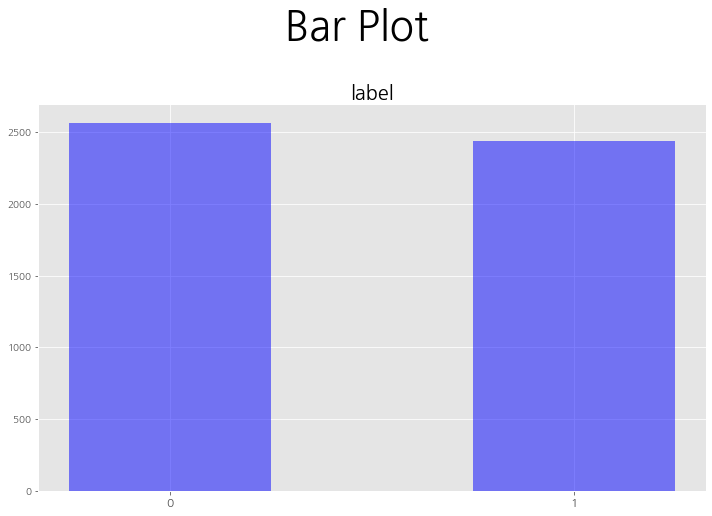

[2564 2436]


In [25]:
feature = data['label'] #label의 데이터 분포를 살펴보기 위해

plt.figure(figsize=(10,7.5)) #그래프 이미지 크기 설정
plt.suptitle('Bar Plot', fontsize=40) #부제목과 폰트 크기

plt.title('label', fontsize=20) # 제목과 폰트 크기
temp = feature.value_counts() # feature 변수의 변수별 개수 계산(0과 1의 개수 계산 후 temp에 저장)
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5) #막대그래프 생성, temp.keys() = 0 or 1 / temp.values = 2564 or 2436 
plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0,0.03,1,0.95]) # 레이아웃
plt.show() #나타내기
print(temp.values)
#두 라벨의 분포가 비슷한 것을 확인

In [26]:
str_len_mean = np.mean(data['document'].str.len()) #리뷰 길이의 평균값 계산
print('리뷰 길이 평균: ',str_len_mean)

리뷰 길이 평균:  27.1352


In [27]:
mask_pos = (data.label==1) #데이터 필터링을 위한 마스크 설정 
mask_neg = (data.label==0) #데이터 필터링을 위한 마스크 설정

#전체/긍정/부정 리뷰 집합 설정
df_train = data.document.copy() # 전체 train 데이터 
df_pos = data.loc[mask_pos,:].document # train 데이터 중 긍정 리뷰만
df_neg = data.loc[mask_neg,:].document # train 데이터 중 부정 리뷰만

compare = [df_train, df_pos, df_neg] # 나눠진 세 집합을 리스트로 묶음
print(len(compare))
print(min(df_train.str.len())) #리뷰 길이 최소 16(x축 범위)
print(max(df_train.str.len())) #리뷰 길이 최대 42(x축 범위)

3
16
42


In [28]:
df_pos.head() # 긍정데이터 확인

1            히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...
2    괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~
5       내인생에 있어 손까락에 꼽히는 영화 원작을 능가한 리메이크작
7          마음이 성숙하고 보면 다르게 보이는 영화.. 걸작이다.
8                   가슴 찡했던, 오래 기억에남을 영화!!
Name: document, dtype: object

In [29]:
df_neg.head() # 부정데이터 확인

0                  영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐
3                아무래도 20년도지난작품이라 지금보기는너무유치하다
4    지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.
6                성룡영화중 최악 .. 차라리 러시아워가 훨씬 나음
9                   결말 기분나쁘다 공포매니아에게 이따위 결말을
Name: document, dtype: object

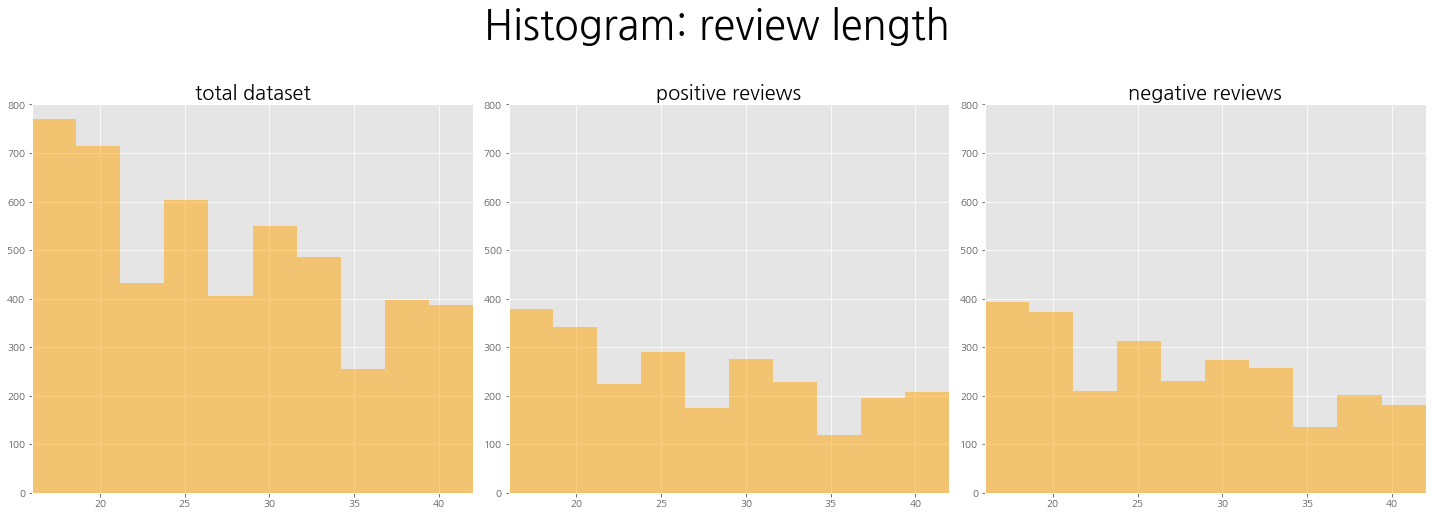

In [30]:
#히스토그램을 사용하여 데이터 분포 살펴보기

plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: review length", fontsize=40) #전체 제목
name = ['total dataset', 'positive reviews', 'negative reviews'] #제목으로 사용

for i in range(len(compare)): #세 집합을 리스트로 묶은 compare의 길이(=3) 만큼 반복
    document = compare[i]
    string_len = [len(x) for x in document]
    plt.subplot(1,3,i+1) #행 개수/ 열 개수/해당 그래프 표시순서
    plt.title(name[i], fontsize=20)
    plt.axis([16,42,0,800]) #axis는 축설정, 순서대로 x축 시작, 끝(문자 길이), y축 시작, 끝(빈도수)
    plt.hist(string_len, alpha=0.5, color='orange')


plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#길이가 짧아질수록 빈도수가 높아짐
#긍정/부정 데이터와 상관없이 리뷰의 길이는 비슷한 분포를 띔


In [31]:
#띄어쓰기 기준으로 각 리뷰 당 포함하는 어절(word) 수 살펴보기

word_split=data['document'].str.split() #공백 기준 문자열 분리한 것을 word_split에 저장
word_split.head()
print(min(word_split.str.len())) #x축 최소값
print(max(word_split.str.len())) #y축 최대값

1
15


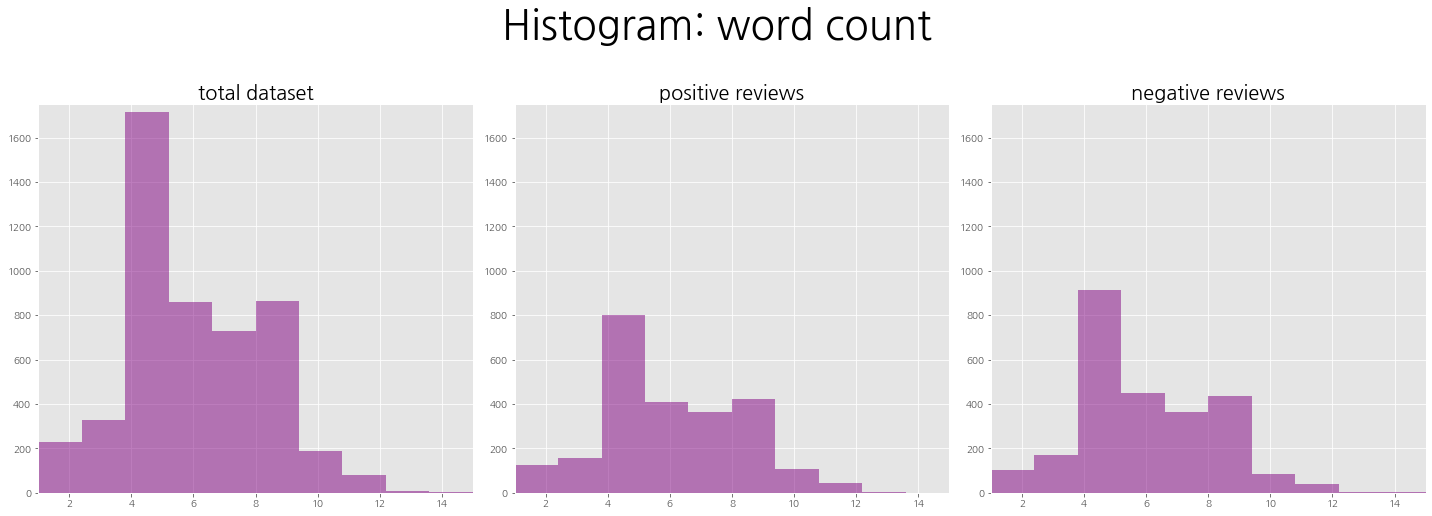

In [32]:
#히스토그램을 사용해서 데이터 분포 살펴보기
plt.figure(figsize=(20,7.5))
plt.suptitle("Histogram: word count", fontsize=40)
name = ['total dataset', 'positive reviews', 'negative reviews'] #제목

for i in range(len(compare)):
    document=compare[i]
    split = document.str.split()
    split_len = [len(x) for x in split]
    plt.subplot(1,3,i+1) #행 개수/열 개수/해당 그래프 표시 순서
    plt.title(name[i], fontsize=20)
    plt.axis([1,15,0,1750]) #x축 시작 끝/ y축 시작 끝
    plt.hist(split_len, alpha=0.5, color='purple')
    
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

#4~6개의 어절로 이루어진 리뷰가 가장 빈도수가 높음
#분포는 세 데이터셋(dataset, pos, neg) 모두 거의 동일

In [33]:
#워드클라우드(Word Cloud)
#문서의 키워드 등을 직관적으로 파악할 수 있도록 하는 시각화 기법
#문서에 자주 언급된 단어일수록 크게 시각화하고 문서에 등장하는 주요 단어들을 한눈에 파악할 수 있음
#문서 빅데이터 분석에 자주 사용

In [53]:
def df2str(df):
    #전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = 'NanumGothic.ttf', # 한글폰트 경로 설정
        background_color='white', # 배경 색깔 정하기
        colormap = 'Dark2', # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

In [54]:
document = df2str(df_train) #전체 리뷰들을 하나의 문자열로 만드는 함수 적용
noun_list = get_noun(document) #명사 추출, 개수 세는 함수 적용
noun_list[:5]
#konlpy 환경변수 삽질,,

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

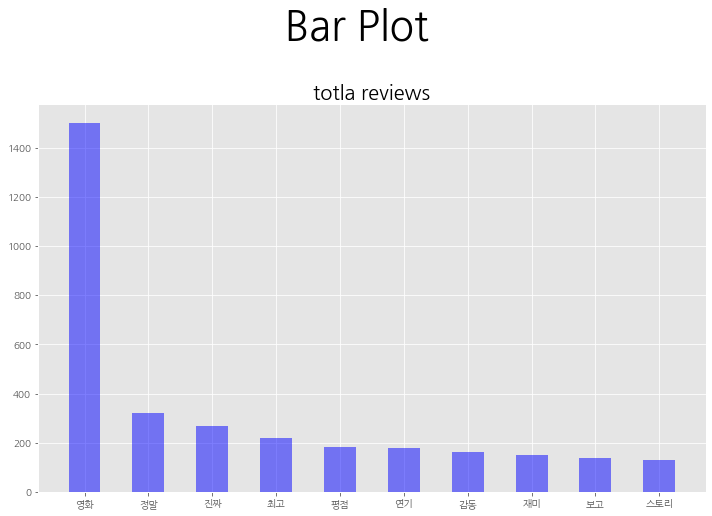

In [55]:
plt.rc('font', family='NanumGothic') #글씨가 깨져서 NanumGothic을 다운 받은 후 실행
top_10 = dict(noun_list[:10]) #추출한 명사 중 상위 10개
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title("totla reviews", fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

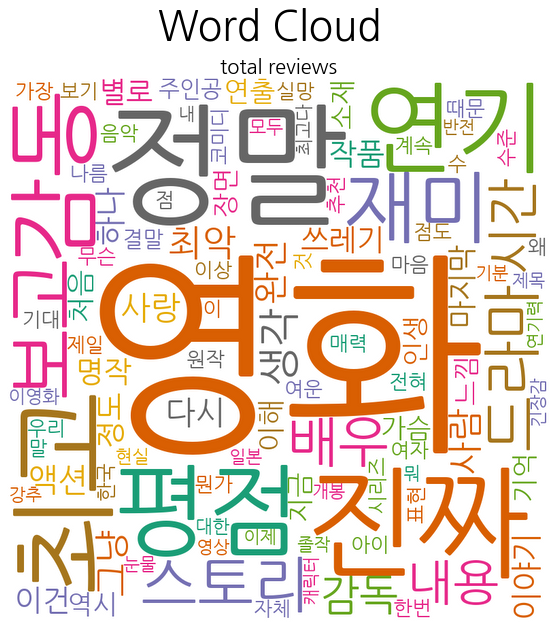

In [56]:
total_reviews = visualize(noun_list,'total reviews') #워드 클라우드 시각화를 위해 visualize 함수 실행(전체 리뷰)

In [58]:
document_p = df2str(df_pos) #긍정 리뷰들을 하나의 문자열로 만드는 함수 적용
noun_list_p = get_noun(document_p) #명사 추출, 빈도수 계산
noun_list_p[:20] #상위 20개 값 확인

[('영화', 757),
 ('정말', 216),
 ('최고', 214),
 ('진짜', 136),
 ('감동', 134),
 ('연기', 108),
 ('드라마', 89),
 ('보고', 88),
 ('사랑', 72),
 ('다시', 70),
 ('평점', 67),
 ('생각', 65),
 ('명작', 60),
 ('배우', 58),
 ('사람', 55),
 ('완전', 54),
 ('마지막', 52),
 ('가슴', 51),
 ('이야기', 50),
 ('재미', 48)]

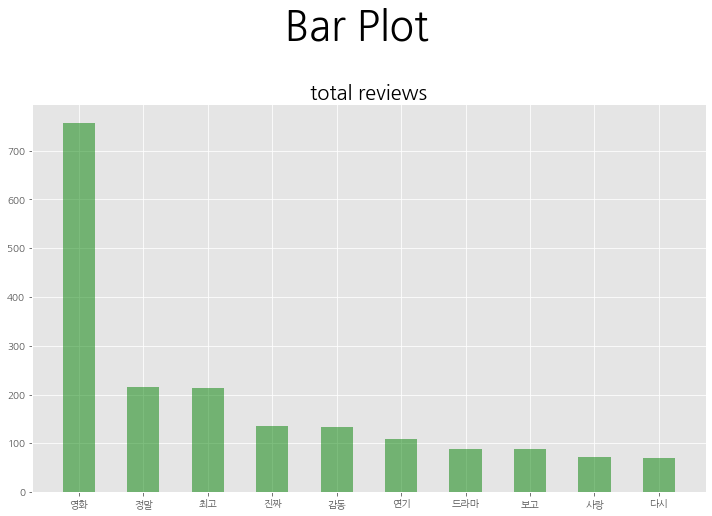

In [59]:
plt.rc('font', family='NanumGothic') 
top_10 = dict(noun_list_p[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='green', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

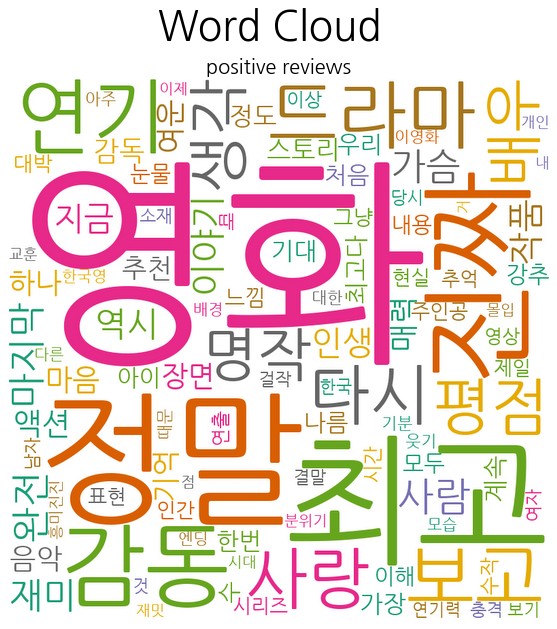

In [60]:
positive_reviews = visualize(noun_list_p, 'positive reviews') #워드 클라우드 시각화를 위해 visualize 함수 실행(긍정 리뷰)

In [61]:
document_n = df2str(df_neg) #부정 리뷰들을 하나의 문자열로 만드는 함수 적용
noun_list_n = get_noun(document_n) #명사 추출, 빈도수 계산
noun_list_n[:20] #상위 20개 값 확인

[('영화', 746),
 ('진짜', 132),
 ('평점', 118),
 ('재미', 104),
 ('정말', 104),
 ('스토리', 102),
 ('최악', 98),
 ('시간', 97),
 ('내용', 85),
 ('감독', 78),
 ('그냥', 75),
 ('연기', 72),
 ('쓰레기', 70),
 ('배우', 69),
 ('이건', 55),
 ('별로', 53),
 ('보고', 52),
 ('액션', 43),
 ('하나', 41),
 ('사람', 41)]

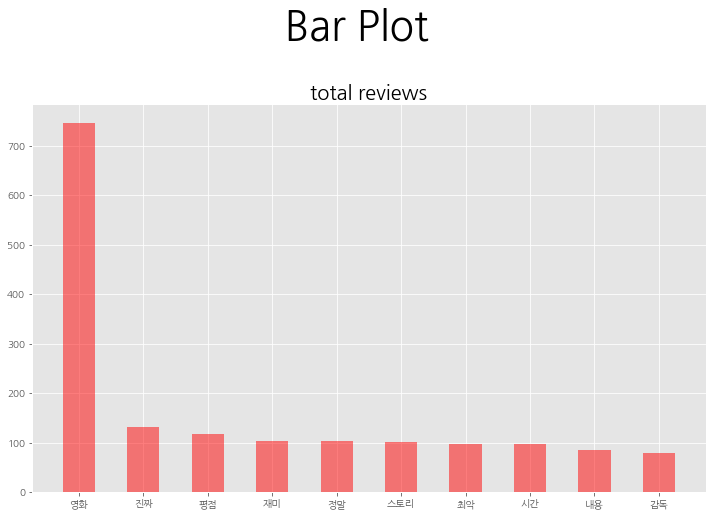

In [62]:
plt.rc('font', family='NanumGothic') 
top_10 = dict(noun_list_n[:10])
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='r', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

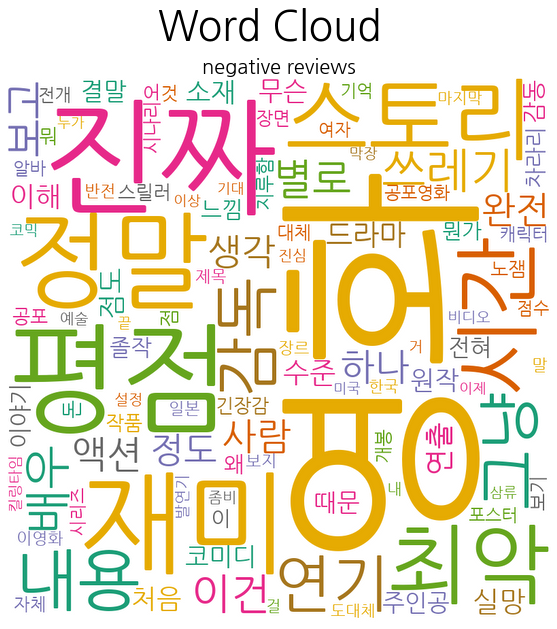

In [63]:
negative_reviews = visualize(noun_list_n, 'negative reviews') #워드 클라우드 시각화를 위해 visualize 함수 실행(부정 리뷰)

In [64]:
# 부정리뷰와 긍정리뷰에서 공통으로 등장하는 단어들을 제거한 후 다시 시각화

#부/긍정 리뷰에서 자주 쓰이는 단어 top10 확인
print("부정리뷰 Top10: ", noun_list_n[:10])
print("긍정리뷰 Top10: ", noun_list_p[:10])

부정리뷰 Top10:  [('영화', 746), ('진짜', 132), ('평점', 118), ('재미', 104), ('정말', 104), ('스토리', 102), ('최악', 98), ('시간', 97), ('내용', 85), ('감독', 78)]
긍정리뷰 Top10:  [('영화', 757), ('정말', 216), ('최고', 214), ('진짜', 136), ('감동', 134), ('연기', 108), ('드라마', 89), ('보고', 88), ('사랑', 72), ('다시', 70)]


In [68]:
neg = list(dict(noun_list_n).keys()) #key(명사)만 이용하여 리스트 생성
pos = list(dict(noun_list_p).keys()) #key(명사)만 이용하여 리스트 생성

drop_words = [x for x in neg if x in pos] #부정리뷰에 포함된 명사가 긍정리뷰에도 포함될 경우 drop_words라는 리스트에 저장
print('공통으로 등장하는 단어 Top 10: ',drop_words[:10])

공통으로 등장하는 단어 Top 10:  ['영화', '진짜', '평점', '재미', '정말', '스토리', '시간', '내용', '감독', '그냥']


In [71]:
noun_list_n_filter = [x for x in noun_list_n if x[0] not in drop_words] #drop_words 리스트에 포함되지 않은 부정리뷰 명사를 저장
noun_list_p_filter = [x for x in noun_list_p if x[0] not in drop_words] #drop_words 리스트에 포함되지 않은 긍정리뷰 명사를 저장



In [70]:
print("정제된 부정 리뷰 상위 단어 Top10\n", noun_list_n_filter[:10])

정제된 부정 리뷰 상위 단어 Top10
 [('최악', 98), ('쓰레기', 70), ('이건', 55), ('별로', 53), ('실망', 36), ('수준', 36), ('점도', 34), ('원작', 31), ('무슨', 31), ('코미디', 29)]


In [73]:
print("정제된 긍정 리뷰 상위 단어 Top10\n", noun_list_p_filter[:10])

정제된 긍정 리뷰 상위 단어 Top10
 [('최고', 214), ('사랑', 72), ('다시', 70), ('명작', 60), ('가슴', 51), ('역시', 44), ('인생', 41), ('지금', 39), ('매력', 35), ('마음', 34)]


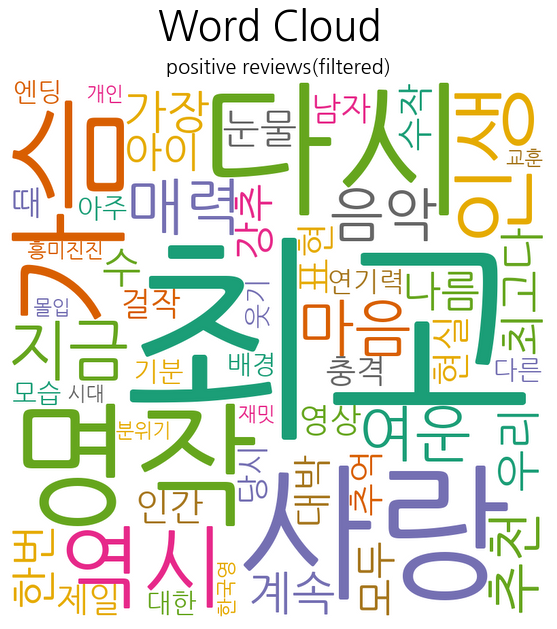

In [74]:
positive_reviews_filtered = visualize(noun_list_p_filter, 'positive reviews(filtered)') #필터된 긍정리뷰 워드클라우드 시각화

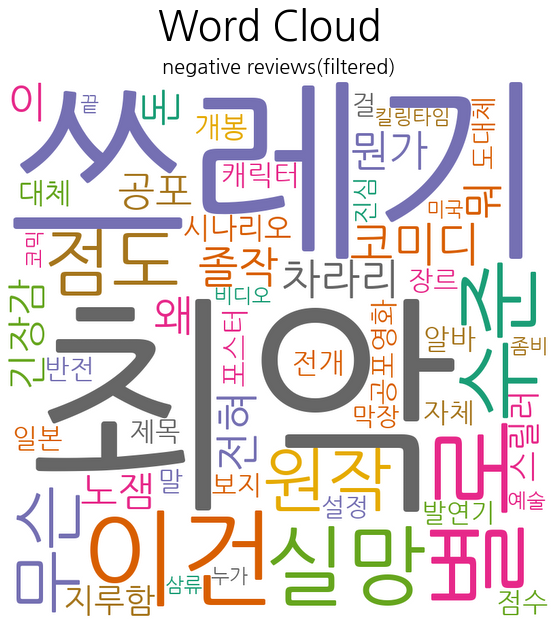

In [75]:
negative_reviews_filtered = visualize(noun_list_n_filter, 'negative reviews(filtered)') #필터된 부정리뷰 워드클라우드 시각화